In [2]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

import json
import os
from dotenv import load_dotenv #pip install python-dotenv

from bs4 import BeautifulSoup
import requests 

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings("ignore")

In [45]:
# comprovar quantes requests he fet i quantes me'n queden

url_search = "https://api.discogs.com/database/search"

params = {
    "type": "release"  # Search for masters
    , "format": "album"           # just search for albums
    , "per_page": 100    # Number of results per page (max 100)
    , "page": 1          # Start with page 1
    , 'country': 'UK'
    , "year": 2015
    , 'genre': 'Rock'
    # , "style": style
}

headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url_search, headers=headers, params=params)

rate_limit = response.headers.get("X-Discogs-Ratelimit")
rate_limit_used = response.headers.get("X-Discogs-Ratelimit-Used")
rate_limit_remaining = response.headers.get("X-Discogs-Ratelimit-Remaining")

print(f"Rate Limit: {rate_limit}")
print(f"Rate Limit Used: {rate_limit_used}")
print(f"Rate Limit Remaining: {rate_limit_remaining}")

Rate Limit: 60
Rate Limit Used: 0
Rate Limit Remaining: 60


### **Proves**: un any en un país

In [70]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Rock", "Stage & Screen"]
rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
              , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

for style in rock_styles:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'UK'
        , 'year': 2010
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")

Pop Rock: 492
Punk: 418
Alternative Rock: 614
Indie Rock: 911
Hardcore: 153
Rock & Roll: 86
Hard Rock: 252
Psychedelic Rock: 428
Black Metal: 199
Heavy Metal: 306
Folk Rock: 386
Experimental: 367
Prog Rock: 386
Death Metal: 184
Garage Rock: 106


In [43]:
# get one style in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100    # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'page': 1

    # items to change
    , 'country': 'UK'
    , 'year': 2015
    , 'genre': 'Rock'
    # , 'style': 'Alternative Rock'
}

response = requests.get(url, headers=headers, params=params)
data = response.json()
items_number = response.json()['pagination']['items']  # number of items

print(f"Items: {items_number}")

# response.json()

Items: 6360


### **Rock masters from a specific country**

In [16]:
df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')
df_masters_scrapped.shape

(21658, 13)

In [45]:
url_search = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')

rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
              , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

# create empty lists
artist_id_list = []
artists_list = []
titles_list = []
years_list = []
release_countries_list = []
album_length_list = []
tracks_list = []
release_type_list = []
genres_list = []
styles_list = []
master_id_new_list = []
artist_profile_list = []
main_release_id_list = []

attempts = 0
scrapped = 0
start_year = 2010

for year in range(start_year, start_year-12, -1):
    print(f'Year: {year}')

    for style in rock_styles:
        print(f'Style: {style}')

        # Define parameters for album search
        params = {
            "type": "release"  # Search for masters
            , "format": "album"           # just search for albums
            , "per_page": 100    # Number of results per page (max 100)
            , "page": 1          # Start with page 1
            , 'country': 'UK'
            , "year": year
            , 'genre': 'Rock'
            , "style": style
        }

        response1 = requests.get(url_search, headers=headers, params=params)
        time.sleep(1)
        data1 = response1.json()

        items = data1['pagination']['items']
        print(f'Items: {items} releases')

        pages = data1['pagination']['pages']+1
        
        for page in range(1, pages):
            print(f'------------ Page: {page} of {pages-1}, {style} of {year} -------------')

            params['page'] = page     # change pages
            response2 = requests.get(url_search, headers=headers, params=params)
            data2 = response2.json()

            for id in range(len(data2['results'])):
                try:
                    attempts+=1
                    time.sleep(1)

                    master_id = data2['results'][id]['master_id']

                    if master_id == 0:
                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}')
                        continue        # I cannot get info 
                    elif master_id in master_id_new_list:
                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already in list') 
                        continue        # there are several releases of the same master_release, I just want one (the master_release)
                    elif master_id in df_masters_scrapped['master_id'].values:
                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scrapped') 
                        continue        # I have already scrapped it before
                    else:
                        url_master = f"https://api.discogs.com/masters/{master_id}"
                        response3 = requests.get(url_master, headers=headers)
                        time.sleep(1)
                        data3 = response3.json()

                        artist = data3['artists'][0]['name']

                        if artist == 'Various':
                                print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: Compilation') 
                                continue   # I don't want compilations
                        else:
                        # define the data I want to get
                            title = data3['title']
                            release_year = data3['year']                 
                            genres = data3['genres']
                            styles = data3['styles']

                        # a more complex information is the total duration of the album, I have to sum the durations of each song
                            number_of_songs = len(data3['tracklist'])
                            song_durations = []

                            for song in range(number_of_songs):
                                song_duration = data3['tracklist'][song]['duration']
                                try:
                                    minutes = int(song_duration.split(':')[0])
                                    seconds = int(song_duration.split(':')[1])
                                    song_duration_minutes = minutes + seconds/60
                                    song_durations.append(song_duration_minutes)
                                except:
                                    pass
                                album_length = round(sum(i for i in song_durations), 2)

                            main_release_id = data3['main_release']
                            artist_id = data3['artists'][0]['id']

                        # release page
                            url = f"https://api.discogs.com/releases/{main_release_id}"
                            time.sleep(1)
                            response4 = requests.get(url, headers=headers)
                            data4 = response4.json()

                        # define the data I want to get
                            release_country = data4['country']
                            release_type = data4['formats'][0]['descriptions']

                        # artist page
                            url = f"https://api.discogs.com/artists/{artist_id}"
                            time.sleep(1)
                            response5 = requests.get(url, headers=headers)
                            data5 = response5.json()

                        # define the data I want to get
                            try:
                                artist_profile = data5['profile']
                            except:
                                artist_profile = np.nan
                                pass

                        # save the info in the lists
                            artist_id_list.append(str(artist_id))
                            artists_list.append(artist)
                            titles_list.append(title)
                            years_list.append(release_year)
                            genres_list.append(genres)
                            styles_list.append(styles)
                            master_id_new_list.append(master_id)
                            album_length_list.append(album_length)
                            tracks_list.append(number_of_songs)
                            release_countries_list.append(release_country)
                            release_type_list.append(release_type)
                            main_release_id_list.append(main_release_id)

                            if artist_profile == '':
                                artist_profile_list.append(np.nan)
                            else:
                                artist_profile_list.append(artist_profile)

                            scrapped+=1

                        # list lengths
                            lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                    , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                        # Check if all lists have the same length
                            lengths = [len(lst) for lst in lists]
                            if len(set(lengths)) != 1:
                                print("Lengths are not the same.")
                                break # stop the loop, I won't be able to store the data if I have one value missing

                            print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: {artist} - {title}')
                            time.sleep(1)
                except:
                    print('Strange error')
                    continue    # sometimes it crashes for some unknown reason, so I skip this album and continue

Year: 2011
Style: Hardcore
Items: 156 releases
------------ Page: 1 of 2, Hardcore of 2011 -------------
1 attempts - 1 scrapped - 1/156 - master_id 446314: Accident Gallery - Battles
2 attempts - 1 scrapped - 2/156 - master_id 0
3 attempts - 2 scrapped - 3/156 - master_id 566136: Dead And Divine - Antimacy
4 attempts - 3 scrapped - 4/156 - master_id 943599: Dead Man's Chest - Hateline
5 attempts - 4 scrapped - 5/156 - master_id 1224023: TRC (2) - Bright Lights
6 attempts - 4 scrapped - 6/156 - master_id 0
7 attempts - 4 scrapped - 7/156 - master_id 0
8 attempts - 4 scrapped - 8/156 - master_id 0
9 attempts - 4 scrapped - 9/156 - master_id 0
10 attempts - 4 scrapped - 10/156 - master_id 0
11 attempts - 5 scrapped - 11/156 - master_id 629933: Section 13 (2) - Burning Bridges
12 attempts - 6 scrapped - 12/156 - master_id 529177: Abolition (5) - Abolition
13 attempts - 6 scrapped - 13/156 - master_id 382767 already scrapped
14 attempts - 6 scrapped - 14/156 - master_id 529177 already in l

In [ ]:
# UK 2011

# Scrapped
# Pop Rock: 490
# Punk: 523
# Alternative Rock: 726
# Hardcore: 156
# Hard Rock: 268

# To scrape
# Indie Rock: 946
# Rock & Roll: 111
# Psychedelic Rock: 501
# Black Metal: 145
# Heavy Metal: 230
# Folk Rock: 375
# Experimental: 371
# Prog Rock: 361
# Death Metal: 158
# Garage Rock: 138


453+904+731+976+254+154+312+633+146+197+326+465+399+133+141

2922

In [31]:
(31*60)/726

2.56198347107438

### **Saving the data**

In [46]:
data = pd.DataFrame({'artist_id': artist_id_list
                        , 'master_id': master_id_new_list
                        , 'main_release_id': main_release_id_list
                        , 'release_country': release_countries_list
                        , 'artist': artists_list
                        , 'title': titles_list
                        , 'year': years_list
                        , 'album_length': album_length_list
                        , 'tracks': tracks_list
                        , 'release_type': release_type_list
                        , 'genres': genres_list
                        , 'styles': styles_list
                        , 'artist_profile': artist_profile_list
                        })
data.shape

(139, 13)

In [47]:
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

139 releases
117 different artists


In [48]:
data.sample(10)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
46,245648,40700,2278302,UK,Rainbow,Bent Out Of Shape,1983,40.35,10,"[LP, Album]",[Rock],[Hard Rock],Rainbow (also known as Ritchie Blackmore's Rai...
51,245648,40606,1575890,UK,Rainbow,Ritchie Blackmore's Rainbow,1975,37.23,9,"[LP, Album, Stereo]",[Rock],"[Hard Rock, Heavy Metal]",Rainbow (also known as Ritchie Blackmore's Rai...
39,363374,210976,1878042,US,Angel City (2),Face To Face,1980,38.70,10,"[LP, Album, Stereo]",[Rock],"[Alternative Rock, Hard Rock]",Angel City was the name used by the Australian...
130,274043,460054,2277059,US,Warrior Soul,Salutations From The Ghetto Nation,1992,56.33,12,[Album],[Rock],"[Hard Rock, Punk]","American hard rock band from NYC, formed in 19..."
62,153677,35268,1642037,UK,UFO (5),Mechanix,1982,40.17,10,"[LP, Album]",[Rock],[Hard Rock],British heavy metal/hard rock band formed in 1...
14,1370899,370802,3004294,UK,Wheelchair Wheelchair Wheelchair Wheelchair,Contraception,2011,23.78,12,[Album],[Rock],"[Thrash, Grindcore, Hardcore]","Grindcore band from Scotland, United Kingdom. ..."
103,301204,918143,7602906,UK,Chris Ousey,Rhyme & Reason,2011,46.48,12,[Album],[Rock],"[Hard Rock, Arena Rock, AOR]",British vocalist.
19,2702858,834071,13048649,UK,Anger Management,Beyond The Threshold Of Pain,2011,0.00,5,"[Album, Promo]",[Rock],"[Thrash, Hardcore, Heavy Metal]",NaN
58,463597,511797,4202793,UK,Alice Cooper (2),No More Mr. Nice Guy Live! (Alexandra Palace -...,2011,98.25,21,[Album],[Rock],[Hard Rock],[b]Note: For early ([i]pre-1975[/i]) releases ...
107,287611,354568,3398505,UK,Firebird,Double Diamond,2010,35.73,10,[Album],[Rock],"[Blues Rock, Stoner Rock, Hard Rock]","Rock band from London, UK. Currently signed wi..."


In [49]:
data.release_country.value_counts().head()

release_country
UK             77
US             22
Europe         10
Germany         8
UK & Europe     6
Name: count, dtype: int64

In [50]:
data.year.value_counts().head()

year
2011    61
2010     8
1980     6
1982     5
1985     4
Name: count, dtype: int64

### **Concat with the previous df**

In [51]:
# import the last df
df_masters = pd.read_csv('Datasets/df_masters.csv')
df_masters.shape

(21997, 13)

In [52]:
# concat with the df of the albums I just scrapped
df_masters_concat = pd.concat([data, df_masters])
df_masters_concat.reset_index(drop=True, inplace=True)
df_masters_concat.shape

(22136, 13)

In [53]:
def check_duplicates(df):
    if df['master_id'].duplicated().sum() == 0:
        print('No duplicates')
    else: 
        duplicates = df['master_id'].duplicated().sum()
        df.drop_duplicates(subset='master_id', inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f'Found {duplicates} duplicates')
        print(f'Resulting dataset: {df.shape}')

In [54]:
check_duplicates(df_masters_concat)

No duplicates


In [55]:
print(f'{df_masters_concat.shape[0]} releases\n{df_masters_concat.artist.nunique()} different artists')

22136 releases
12436 different artists


### **Exporting to csv**

In [56]:
df_masters_concat.to_csv('Datasets/df_masters.csv', index=False)

In [ ]:
# # import the last df
# df_masters_concat = pd.read_csv('Datasets/df_masters.csv')

### **Statistics**

In [57]:
df_masters_concat.year.value_counts().head(10)

year
2017    1298
2020    1256
2018    1247
2016    1239
2019    1213
2012    1198
2014    1186
2015    1181
2013    1133
2021    1082
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='year'>

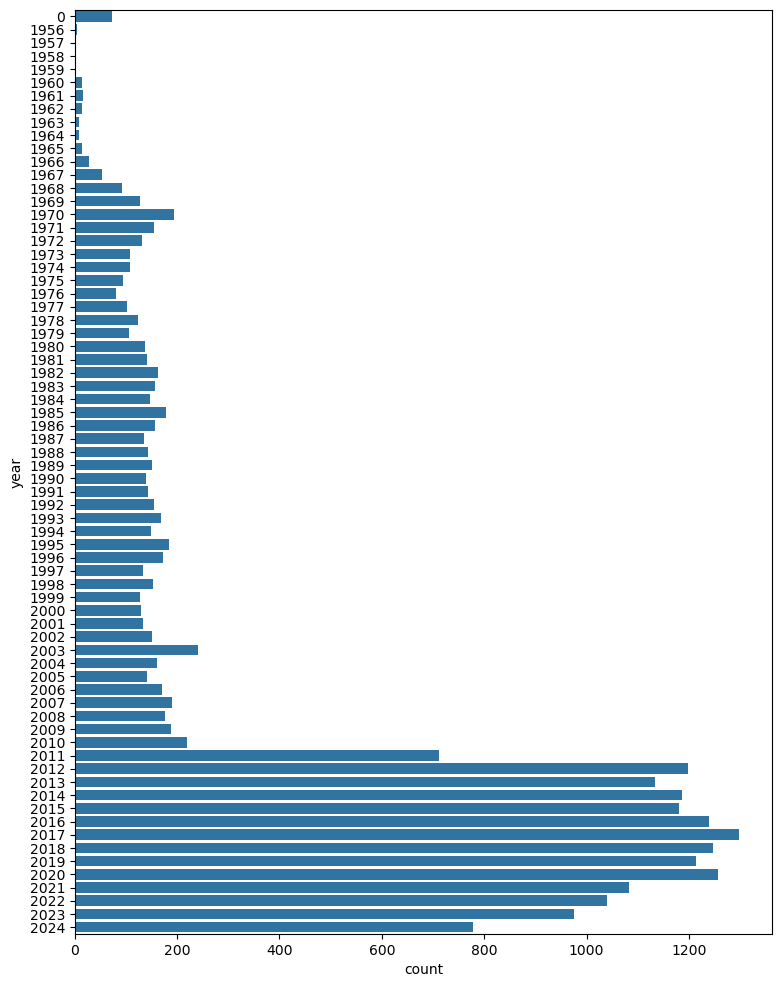

In [58]:
plt.figure(figsize=(9,12))
sns.countplot(data=df_masters_concat, y='year')

In [59]:
df_masters_concat.release_country.value_counts().head(10)

release_country
UK                 12126
US                  3394
Europe              1442
UK & Europe         1101
Germany              476
UK, Europe & US      397
UK & US              315
Australia            239
Canada               233
Worldwide            213
Name: count, dtype: int64

In [22]:
df_masters_concat[df_masters_concat['artist']=='King Gizzard And The Lizard Wizard'].sort_values('year', ascending=False)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2673,2532180,3459911,30468428,US,King Gizzard And The Lizard Wizard,Nonagon Infinity Live,2024,41.17,8,"['LP', 'Compilation', 'Limited Edition']",['Rock'],"['Garage Rock', 'Psychedelic Rock']","Psychedelic rock band from Melbourne, Victoria..."
10717,2532180,2079445,18303538,France,King Gizzard And The Lizard Wizard,Demos Vol. 1. (Music To Kill Bad People To),2021,44.47,14,"['LP', 'Album', 'Limited Edition']",['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria..."
10836,2532180,2331730,20525803,UK & Europe,King Gizzard And The Lizard Wizard,Bootleg Box Set,2021,0.00,135,"['Compilation', 'Limited Edition', 'Numbered']",['Rock'],"['Psychedelic Rock', 'Thrash', 'Heavy Metal']","Psychedelic rock band from Melbourne, Victoria..."
10799,2532180,2464735,17317687,UK,King Gizzard And The Lizard Wizard,Chilled Gizzard,2021,0.00,15,"['Album', 'Compilation', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Garage Rock', 'Blues Rock']","Psychedelic rock band from Melbourne, Victoria..."
7577,2532180,2149990,18939442,Australia,King Gizzard And The Lizard Wizard,Live In Sydney '21,2021,89.62,16,['FLAC'],['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria..."
10728,2532180,2075629,18075865,France,King Gizzard And The Lizard Wizard,Demos Vol. 2. (Music To Eat Bananas To),2021,47.12,14,"['LP', 'Album', 'Limited Edition']",['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria..."
7667,2532180,1996411,17581906,Australia,King Gizzard And The Lizard Wizard,L​.​W.,2021,42.10,9,"['FLAC', 'Album']",['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria..."
10723,2532180,2037586,17939092,Australia,King Gizzard And The Lizard Wizard,Live In Melbourne '21,2021,88.85,18,"['FLAC', 'Album']",['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria..."
8727,2532180,1897413,14661823,Australia,King Gizzard And The Lizard Wizard,Live In Brussels '19,2020,95.42,17,"['FLAC', 'Album']",['Rock'],['Psychedelic Rock'],"Psychedelic rock band from Melbourne, Victoria..."
10807,2532180,1888098,16620795,Australia,King Gizzard And The Lizard Wizard,Teenage Gizzard,2020,29.45,10,"['FLAC', 'Compilation']",['Rock'],"['Psychedelic Rock', 'Surf']","Psychedelic rock band from Melbourne, Victoria..."


In [60]:
df_masters_concat.artist.value_counts().head(10)

artist
The Fall                              54
Dynamo Snackbar                       32
King Crimson                          32
Bob Dylan                             29
King Gizzard And The Lizard Wizard    28
Schroedinger's Cat                    28
Six By Seven                          28
Saxon                                 27
Marillion                             27
UK Subs                               26
Name: count, dtype: int64

In [61]:
df_masters_concat.genres.value_counts().head(10)

genres
['Rock']                                     15252
['Electronic', 'Rock']                        1716
['Rock', 'Pop']                               1594
['Rock', 'Folk, World, & Country']             810
['Electronic', 'Rock', 'Pop']                  364
['Jazz', 'Rock']                               211
['Rock', 'Pop', 'Folk, World, & Country']      203
['Rock', 'Blues']                              179
[Rock]                                         132
['Electronic']                                 131
Name: count, dtype: int64

In [62]:
df_masters_concat.styles.value_counts().head(10)

styles
['Indie Rock']                        1292
['Punk']                               845
['Alternative Rock']                   787
['Prog Rock']                          694
[]                                     659
['Black Metal']                        529
['Psychedelic Rock']                   474
['Hard Rock']                          400
['Pop Rock']                           363
['Alternative Rock', 'Indie Rock']     343
Name: count, dtype: int64

In [63]:
df_masters_concat[df_masters_concat['release_country']=='Europe'].sort_values('artist')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
20300,178047,1304687,11439863,Europe,1/2 Japanese,Why Not?,2018,39.45,13,['Album'],['Rock'],['Indie Rock'],Half Japanese is an art punk band formed by br...
6830,156155,118883,737915,Europe,3 Mustaphas 3,Shopping,1987,44.72,9,"['LP', 'Album']","['Rock', 'Folk, World, & Country']",['Folk Rock'],British band [b]3 Mustaphas 3[/b] did much to ...
3734,3750880,703810,5842611,Europe,5 Seconds Of Summer,5 Seconds Of Summer,2014,39.42,12,['Album'],['Pop'],[],5 Seconds Of Summer (5SOS) is an Australian po...
9690,3750880,1706746,15028328,Europe,5 Seconds Of Summer,CALM,2020,39.50,12,['Album'],"['Rock', 'Pop']","['Pop Rock', 'Power Pop']",5 Seconds Of Summer (5SOS) is an Australian po...
6327,103279,219113,2075252,Europe,60ft Dolls,The Big 3,1996,41.67,13,['Album'],['Rock'],"['Britpop', 'Indie Rock', 'Hard Rock']","Rock trio from Newport, South Wales, in the st..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6089,3971017,725754,6023794,Europe,frnkiero andthe cellabration.,.Stomachaches.,2014,0.00,12,['Album'],['Rock'],[],NaN
1451,336754,441744,3644292,Europe,iLiKETRAiNS,The Shallows,2012,41.52,9,['Album'],"['Electronic', 'Rock']","['Indie Rock', 'Post Rock']",British alternative/post-rock band founded in ...
8745,12268465,3149436,27982503,Europe,sign crushes motorist,Hurting,2023,30.42,10,"['Album', 'Limited Edition', 'Stereo']",['Rock'],"['Alternative Rock', 'Indie Rock', 'Noisecore']",Add as Sign Crushes Motorist
14401,5609390,1558662,13757895,Europe,whenyoung,Reasons To Dream,2019,41.67,11,['Album'],['Rock'],['Alternative Rock'],"Whenyoung is an Irish indie rock group, origin..."


In [64]:
percentage_album_length_missing = round((df_masters_concat['album_length']==0).sum() / df_masters_concat.shape[0] * 100, 2)
print(f'% missing album_length: {percentage_album_length_missing}%')

% missing album_length: 40.71%


In [65]:
df_masters_concat['artist_profile'].isna().sum()

3067

In [66]:
percentage_artist_profile_missing = round(df_masters_concat['artist_profile'].isna().sum() / df_masters_concat.shape[0] * 100, 2)
print(f'% missing artist_profile: {percentage_artist_profile_missing}%')

% missing artist_profile: 13.86%


In [69]:
df_masters_concat[df_masters_concat['artist_profile']==''] # should be empty

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [19]:
df_masters_concat.loc[10, 'artist_profile']

'English Pop punk band from Southend-on-Sea, Essex, consisting of James Bourne, Matt Willis and Charlie Simpson. Formed in 2000, the band had four UK number-one singles, won two Brit awards and have released four studio albums, selling in excess of five million records.\r\n\r\nIn 2003, Dutch releases of this band were released under the artist name "Bust" to avoid confusion with Dutch band [a493201] who had a hit back then with "We Want More".'

In [68]:
df_masters_concat.groupby(["release_country", 'year']).agg({'master_id': 'count'}).sort_values('master_id', ascending=False).astype(int).head(15)

master_id
release_country year           
UK              2020        741
                2019        718
                2018        717
                2017        700
                2016        677
                2015        666
                2012        650
                2014        645
                2013        615
                2021        602
                2022        577
                2023        551
                2024        428
                2011        372
US              2012        217